In [1]:
%load_ext autoreload
%autoreload 2

# Human Tonsil (SlideTags)

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys 
import commot as ct

sys.path.append('../../src')
sys.path.append('..')

from spaceoracle.tools.network import expand_paired_interactions
# from spaceoracle.tools.network import get_human_housekeeping_genes
from spaceoracle.oracles import BaseTravLR
from spaceoracle.tools.network import encode_labels
from spaceoracle.tools.utils import scale_adata

import celloracle as co

In [7]:
%matplotlib inline

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns

# to generate a visually appealing images with dataframes
import dataframe_image as dfi

# to make functions with some arguments fixed
from functools import partial

# Latex typefaces will be used for math symbols in figures.
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]
})

In [69]:
# Human Tonsil snRNAseq from SlideTags
# https://www.nature.com/articles/s41586-023-06837-4


adata = sc.read_h5ad('/Users/koush/Downloads/slidetags_human_tonsil/human_tonsil.h5ad')
adata = adata[:, [gene for gene in adata.var_names if not bool(re.search(r'\.\d+$', gene))]]
del adata.uns
adata = scale_adata(adata, cell_size=10)
adata

AnnData object with n_obs × n_vars = 5778 × 19171
    obs: 'cell_type'
    obsm: 'spatial', 'spatial_unscaled'

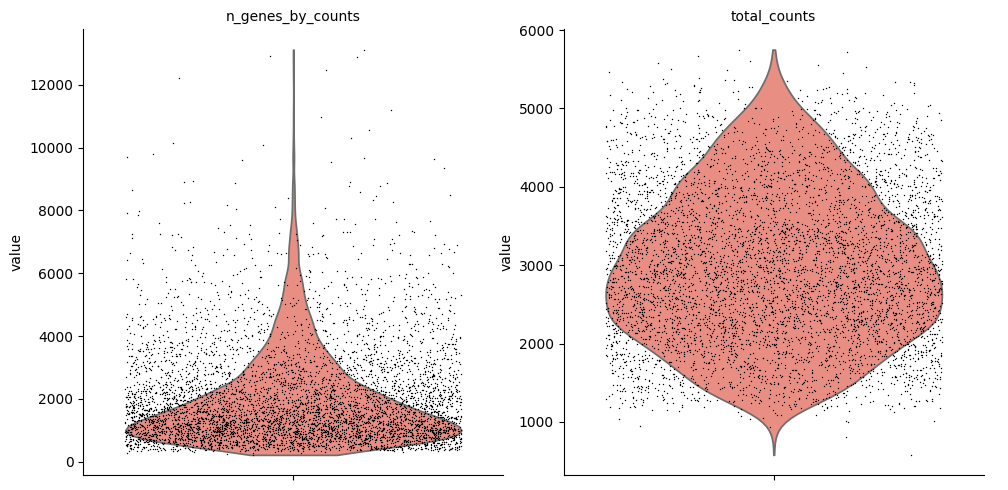

In [3]:
adata = sc.read_h5ad('/Users/koush/Downloads/slidetags_human_tonsil/human_tonsil.h5ad')

sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts'],
    jitter=0.4,
    multi_panel=True,
    color='salmon',
)

In [70]:
base_GRN = co.data.load_human_promoter_base_GRN()

df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='human', 
        signaling_type=None
    )
            
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']
df_ligrec = expand_paired_interactions(df_ligrec)

extra_genes = np.unique(['FOXO1', 'BATF', 'BACH2', 'PRDM1', 'BCL6', 'FOXP3', 'SATB1', 'ID2', 'PAX5', 
    'CXCR4', 'CD83', 'CD86', 'AICDA', 'BCL2A1', 'BCL2', 'LMO2', 'CXCL13', 
    'CD80', 'TRAF3', 'CCL19', 'CCR7', 'CCL21', 'CD40LG', 'CD40', 'IRF4', 'IRF8', 
    'ITGA5', 'ITGB1', 'ITGAM', 'ITGB2', 'CCR6', 'CD19', 'LGALS9',
    'BCL2', 'IL2', 'IL4', 'CD83', 'CD86', 'SDF4', 'SDF2', 'SDF2L1', 
    'S1PR1', 'BMS1P14', 'S1PR3', 'S1PR4', 'S1PR2', 'EBI3', 'CD28', 
    'MICOS10', 'ICOS', 'MICOS13', 'ICOSLG', 'PDCD11', 'PDCD1', 'CD274', 
    'PDCD1LG2', 'TICAM2', 'ICAM2', 'TICAM1', 'EPCAM', 'ICAM1', 'ICAM3', 
    'VCAM1', 'CXCR4', 'CXCR5',  'CXCL13', 'CXCL14', 'CXCL12', 'CR2', 'NFKBIZ', 
    'NFKB1', 'NFKBIL1', 'NFKBIE', 'NFKB2', 'NFKBIA', 'NFKBID', 'NFKBIB', 
    'IL6R', 'IL6ST', 'EGR1', 'EGR3', 'EGR2', 'GATA3', 'TBX21', 'STAT3', 
    'STAT1', 'STAT4', 'STAT6', 'IL4', 'IL6ST', 'IL6', 'IL17A', 'CCR4', 'CCL5'])

len(extra_genes)

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


87

In [71]:
adata = adata[:, ~adata.var_names.str.contains('RIK')]
adata = adata[:, ~adata.var_names.str.contains(r'^HB\w+-\w+$')]
adata = adata[:, ~adata.var_names.str.contains('HP')]
adata = adata[:, ~adata.var_names.str.startswith('RP')]
adata = adata[:, ~adata.var_names.str.startswith('AA')]
adata = adata[:, ~adata.var_names.str.startswith('AB')]
adata = adata[:, ~adata.var_names.str.startswith('AC')]
adata = adata[:, ~adata.var_names.str.startswith('GM')]
adata = adata[:, ~adata.var_names.str.startswith('MIR')]
adata = adata[:, ~adata.var_names.str.startswith('TTT')]
adata = adata[:, ~adata.var_names.str.startswith('LINC')]
adata = adata[:, ~adata.var_names.str.endswith('-AS1')]

In [72]:
n_top_genes = 3500
min_cells = 10
min_counts = 50

In [73]:
adata.var_names_make_unique()
adata.var["MT"] = adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(adata, qc_vars=["MT"], inplace=True)
sc.pp.filter_cells(adata, min_counts=min_counts)
adata = adata[adata.obs["pct_counts_MT"] < 10].copy()
adata = adata[:, ~adata.var["MT"]]

sc.pp.filter_genes(adata, min_cells=min_cells)
adata.layers["normalized_count"] = adata.to_df().values.copy()

ligand_receptor_genes = np.intersect1d(
    adata.var_names, 
    df_ligrec.ligand.unique().tolist()+df_ligrec.receptor.unique().tolist())

lr_df = adata.to_df(layer='normalized_count').join(
    adata.obs.cell_type).groupby('cell_type').mean()[
        ligand_receptor_genes].mean().sort_values(ascending=False).to_frame().reset_index()
lr_df.columns = ['genes', 'expr']

lr_df['mean_expr'] = lr_df['genes'].apply(lambda x: adata.to_df(layer='normalized_count')[x].mean())
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=3000)

adata = adata[:, (adata.var.highly_variable | adata.var_names.isin(list(extra_genes)+lr_df.query('expr > 0.005').genes.to_list()))]

adata

View of AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'normalized_count'

In [74]:
for key in ['n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_MT',
       'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts']:
    if key in adata.obs.keys():
        adata.obs.pop(key)

for key in ['MT', 'RP', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts',
       'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
       'n_cells', 'highly_variable', 'means', 'dispersions',
       'dispersions_norm']:
    if key in adata.var.keys():
        adata.var.pop(key)

del adata.uns

In [75]:
adata.obs['author_cell_type'] = adata.obs['cell_type'].copy()

In [76]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_int'] = adata.obs['cell_type'].apply(
    lambda x: encode_labels(adata.obs['cell_type'], reverse_dict=True)[x])

In [77]:
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'normalized_count'

In [78]:
adata.obs = adata.obs.join(pd.read_csv('banksy_celltypes.csv', index_col=0))

In [79]:
BaseTravLR.impute_clusterwise(adata)

Imputing clusterwise: 100%|██████████| 13/13 [01:02<00:00,  4.79s/it]


In [80]:
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'normalized_count', 'imputed_count'

In [93]:
adata.write_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')